# 📝 Exercise M4.03

Now, we tackle a more realistic classification problem instead of making a
synthetic dataset. We start by loading the Adult Census dataset with the
following snippet. For the moment we retain only the **numerical features**.

In [1]:
import pandas as pd

adult_census = pd.read_csv("../datasets/adult-census.csv")
target = adult_census["class"]
data = adult_census.select_dtypes(["integer", "floating"])
data = data.drop(columns=["education-num"])
data

,age,capital-gain,capital-loss,hours-per-week
0,25,0,0,40
1,38,0,0,50
2,28,0,0,40
3,44,7688,0,40
4,18,0,0,30
...,...,...,...,...
48837,27,0,0,38
48838,40,0,0,40
48839,58,0,0,40
48840,22,0,0,20


We confirm that all the selected features are numerical.

Compute the generalization performance in terms of accuracy of a linear model
composed of a `StandardScaler` and a `LogisticRegression`. Use a 10-fold
cross-validation with `return_estimator=True` to be able to inspect the
trained estimators.

In [2]:
# Write your code here.
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

baseline_model = make_pipeline(StandardScaler(), LogisticRegression())

cv_results = cross_validate(baseline_model, data, target, cv=10, return_estimator=True)

scores = cv_results["test_score"]

print(
    "The mean cross-validation test accuracy is: "
    f"{scores.mean():.3f} ± {scores.std():.3f} "
)

The mean cross-validation test accuracy is: 0.800 ± 0.004 


What is the most important feature seen by the logistic regression?

You can use a boxplot to compare the absolute values of the coefficients while
also visualizing the variability induced by the cross-validation resampling.

In [3]:
# Write your code here.
import numpy as np

coefficients = []
for estimator in cv_results['estimator']:
    coefficients.append(np.ravel(estimator[-1].coef_))

coefficients = pd.DataFrame(coefficients, columns=data.columns)

coefficients.head()

,age,capital-gain,capital-loss,hours-per-week
0,0.522043,2.466777,0.306030,0.539635
1,0.526067,2.406533,0.308178,0.541824
2,0.524257,2.455923,0.308124,0.543843
3,0.520375,2.450482,0.309170,0.534597
4,0.519259,2.512010,0.304243,0.546715


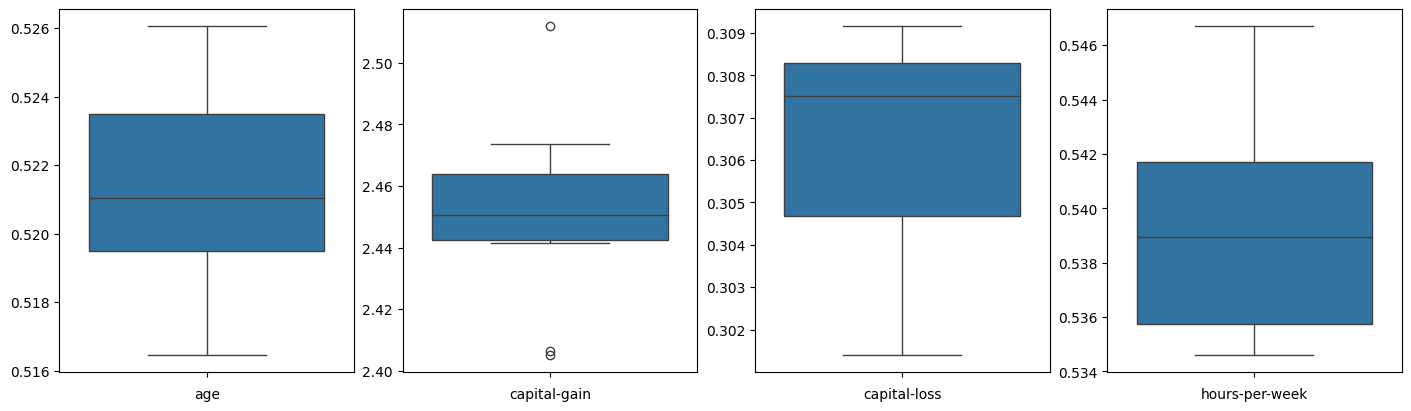

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=coefficients.shape[1], figsize=(14, 4), constrained_layout=True)

for i, ax in enumerate(axs):
    sns.boxplot(data=coefficients.iloc[:,i], ax=ax)
    ax.set(ylabel='', xlabel=coefficients.columns[i])

Let's now work with **both numerical and categorical features**. You can
reload the Adult Census dataset with the following snippet:

In [5]:
adult_census = pd.read_csv("../datasets/adult-census.csv")
target = adult_census["class"]
data = adult_census.drop(columns=["class", "education-num"])

data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


Create a predictive model where:
- The numerical data must be scaled.
- The categorical data must be one-hot encoded, set `min_frequency=0.01` to
  group categories concerning less than 1% of the total samples.
- The predictor is a `LogisticRegression`. You may need to increase the number
  of `max_iter`, which is 100 by default.

Use the same 10-fold cross-validation strategy with `return_estimator=True` as
above to evaluate this complex pipeline.

In [7]:
# Write your code here.
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

numerical_preprocessor = StandardScaler()
categorical_preprocessor = OneHotEncoder(min_frequency=0.01, sparse_output=False, handle_unknown="ignore")

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
        ("standard_scaler", numerical_preprocessor, numerical_columns),
    ]
)

full_model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))
full_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                min_frequency=0.01,
                                                                sparse_output=False),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['age', 'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [8]:
preprocessor.set_output(transform="pandas").fit_transform(data.iloc[:5,:])

,one-hot-encoder__workclass_ ?,one-hot-encoder__workclass_ Local-gov,one-hot-encoder__workclass_ Private,one-hot-encoder__education_ 11th,one-hot-encoder__education_ Assoc-acdm,one-hot-encoder__education_ HS-grad,one-hot-encoder__education_ Some-college,one-hot-encoder__marital-status_ Married-civ-spouse,one-hot-encoder__marital-status_ Never-married,one-hot-encoder__occupation_ ?,...,one-hot-encoder__relationship_ Own-child,one-hot-encoder__race_ Black,one-hot-encoder__race_ White,one-hot-encoder__sex_ Female,one-hot-encoder__sex_ Male,one-hot-encoder__native-country_ United-States,standard_scaler__age,standard_scaler__capital-gain,standard_scaler__capital-loss,standard_scaler__hours-per-week
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,-0.603023,-0.5,0.0,0.000000
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.796851,-0.5,0.0,1.581139
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,-0.279975,-0.5,0.0,0.000000
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.442947,2.0,0.0,0.000000
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,-1.356801,-0.5,0.0,-1.581139


By comparing the cross-validation test scores of both models fold-to-fold,
count the number of times the model using both numerical and categorical
features has a better test score than the model using only numerical features.

In [9]:
# Write your code here.
cv_results_2 = cross_validate(full_model, data, target, cv=10, return_estimator=True)

scores_full_model = cv_results_2["test_score"]

print(
    "The mean cross-validation test accuracy is: "
    f"{scores_full_model.mean():.3f} ± {scores_full_model.std():.3f} "
)

The mean cross-validation test accuracy is: 0.851 ± 0.003 


I will use `np.set_printoptions` in order to edit the print format of the coefficients.
For further info, read [this link](https://stackoverflow.com/questions/2891790/pretty-print-a-numpy-array-without-scientific-notation-and-with-given-precision).

In [53]:
np.set_printoptions(precision=4)
print('The scores for the baseline model are:', scores, sep='\n')
print('The scores for the full model are:', scores_full_model, sep='\n')
print(f"fold-to-fold comparison: {(scores_full_model > scores).sum()}")


The scores for the baseline model are:
[0.7986 0.7928 0.7967 0.8049 0.8004 0.7991 0.7975 0.7993 0.8051 0.8041]
The scores for the full model are:
[0.853  0.8514 0.8495 0.8479 0.8483 0.8468 0.855  0.8501 0.8585 0.8518]
fold-to-fold comparison: 10


For the following questions, you can copy and paste the following snippet to
get the feature names from the column transformer here named `preprocessor`.

```python
preprocessor.fit(data)
feature_names = (
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(
        categorical_columns
    )
).tolist()
feature_names += numerical_columns
feature_names
```

In [10]:
# Checking the existing keys/values
dict(preprocessor.named_transformers_)

{'one-hot-encoder': OneHotEncoder(handle_unknown='ignore', min_frequency=0.01, sparse_output=False),
 'standard_scaler': StandardScaler()}

In [11]:
# Write your code here.
preprocessor.fit(data)
feature_names = (
    preprocessor.named_transformers_["one-hot-encoder"].get_feature_names_out(categorical_columns)
    ).tolist()
feature_names += numerical_columns
feature_names


['workclass_ ?',
 'workclass_ Federal-gov',
 'workclass_ Local-gov',
 'workclass_ Private',
 'workclass_ Self-emp-inc',
 'workclass_ Self-emp-not-inc',
 'workclass_ State-gov',
 'workclass_infrequent_sklearn',
 'education_ 10th',
 'education_ 11th',
 'education_ 12th',
 'education_ 5th-6th',
 'education_ 7th-8th',
 'education_ 9th',
 'education_ Assoc-acdm',
 'education_ Assoc-voc',
 'education_ Bachelors',
 'education_ Doctorate',
 'education_ HS-grad',
 'education_ Masters',
 'education_ Prof-school',
 'education_ Some-college',
 'education_infrequent_sklearn',
 'marital-status_ Divorced',
 'marital-status_ Married-civ-spouse',
 'marital-status_ Married-spouse-absent',
 'marital-status_ Never-married',
 'marital-status_ Separated',
 'marital-status_ Widowed',
 'marital-status_infrequent_sklearn',
 'occupation_ ?',
 'occupation_ Adm-clerical',
 'occupation_ Craft-repair',
 'occupation_ Exec-managerial',
 'occupation_ Farming-fishing',
 'occupation_ Handlers-cleaners',
 'occupation_ Ma

Notice that there are as many feature names as coefficients in the last step
of your predictive pipeline.

Which of the following pairs of features is most impacting the predictions of
the logistic regression classifier based on the absolute magnitude of its
coefficients?

In [12]:
full_model.fit(data, target)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                min_frequency=0.01,
                                                                sparse_output=False),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['age', 'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [13]:
abs(full_model[-1].coef_)

array([[0.15916878, 0.67005322, 0.03134676, 0.17586841, 0.31700564,
        0.36848829, 0.14462274, 0.49244551, 0.93128063, 0.84095866,
        0.41085365, 1.01645046, 1.329303  , 1.14246771, 0.50274901,
        0.40279763, 1.03391398, 1.90338969, 0.0843467 , 1.35705199,
        1.84886171, 0.28190468, 1.54545916, 0.58307046, 1.65972526,
        0.4240349 , 1.00795126, 0.63432001, 0.50618901, 1.52538909,
        0.30154954, 0.12186376, 0.18763583, 0.88492723, 0.84623434,
        0.55576441, 0.18687454, 0.75894471, 0.65877722, 0.60421361,
        0.37368962, 0.6798684 , 0.0127486 , 0.84480804, 0.12157642,
        0.36538848, 0.66677959, 0.72180452, 0.16956916, 1.0047516 ,
        0.13445499, 0.05065983, 0.16792314, 0.2221696 , 0.34117043,
        0.37071914, 0.10012142, 0.52142529, 0.290581  , 0.16027157,
        0.33799356, 2.34627779, 0.25896213, 0.35374374]])

<Axes: >

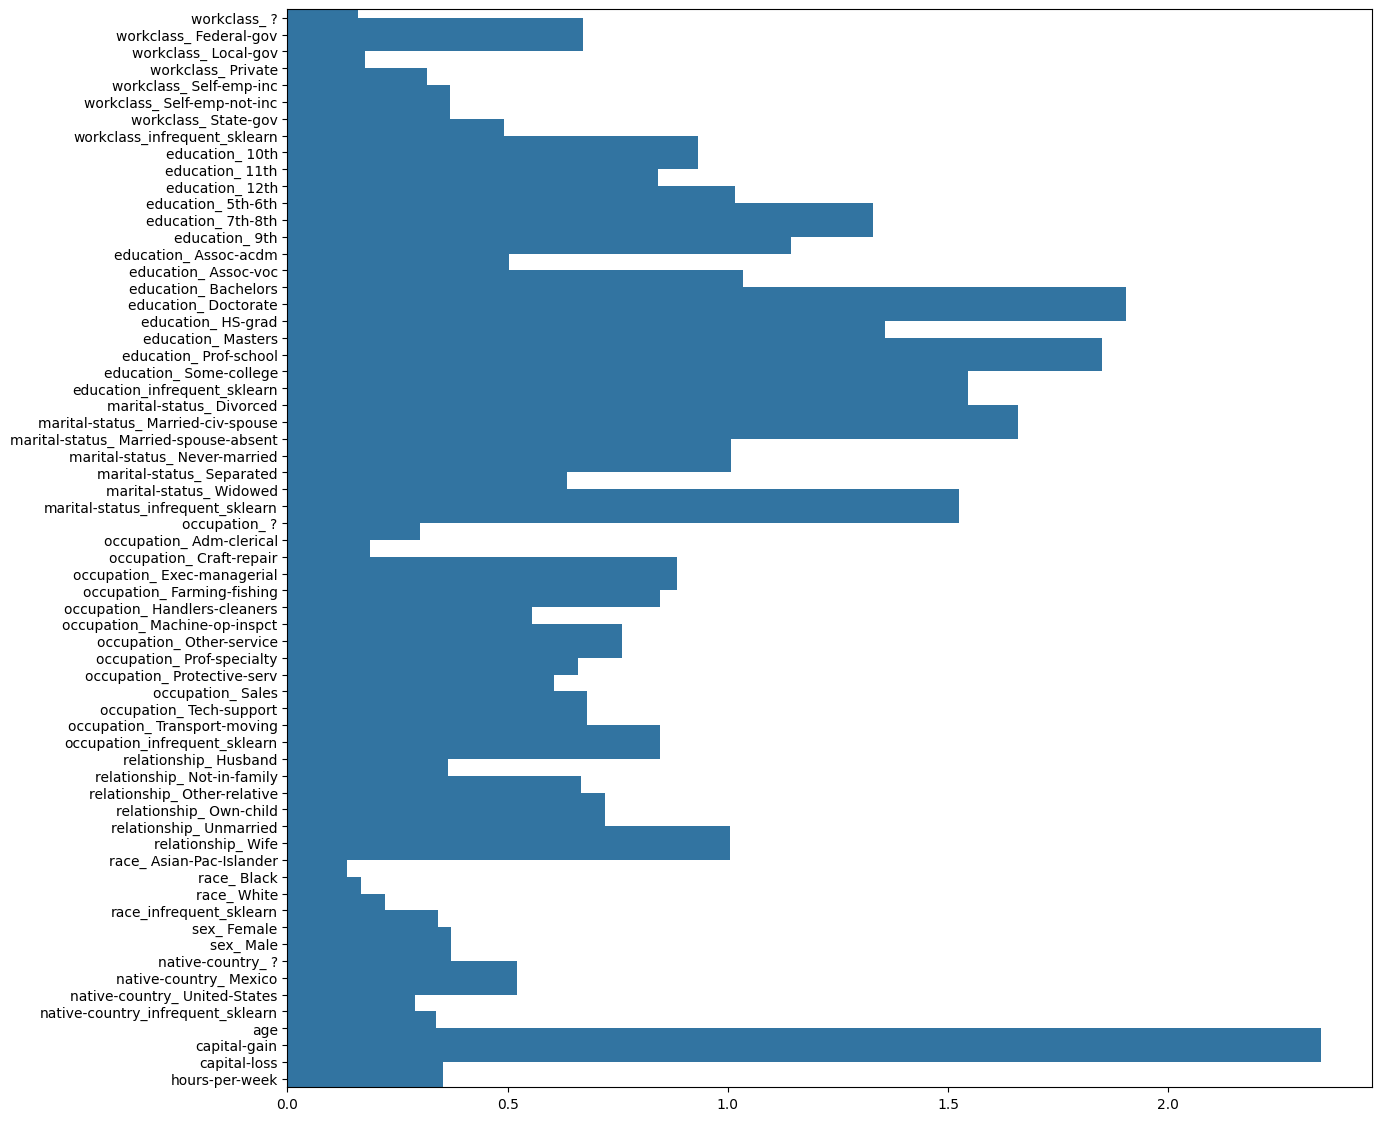

In [31]:
# Write your code here.
plt.figure(figsize=(14,14))
sns.barplot(x=abs(np.ravel(full_model[-1].coef_)), y=feature_names, width=2)

In sorted order,

<Axes: >

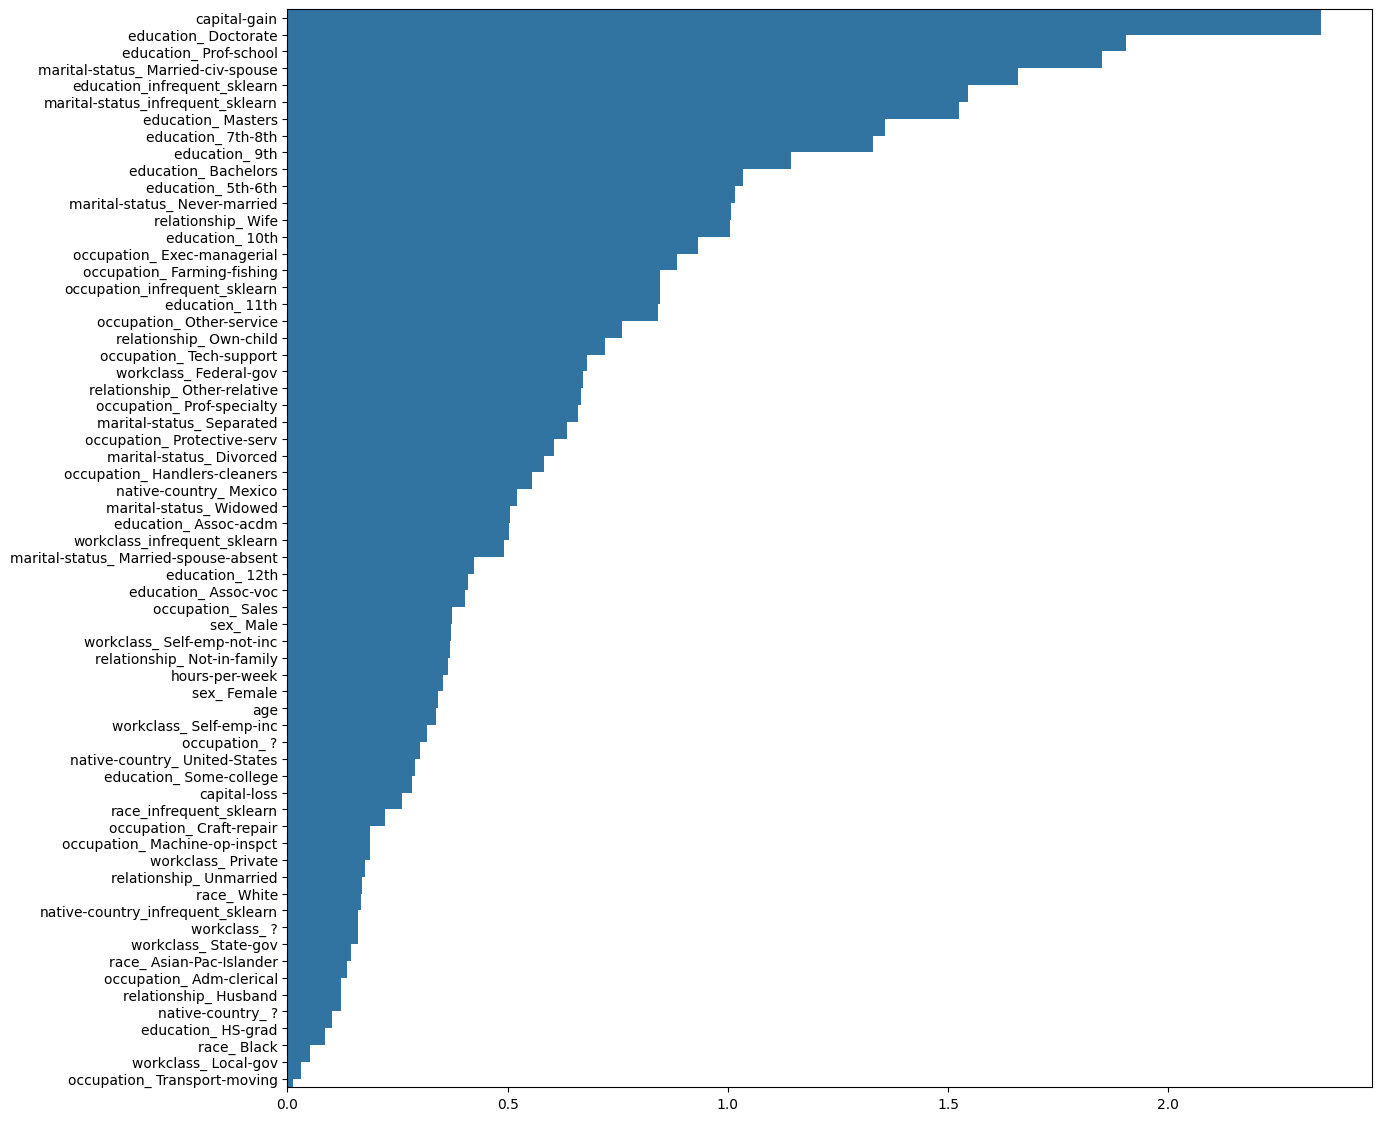

In [74]:
final_coefficients_data = dict(zip(feature_names, abs(np.ravel(full_model[-1].coef_))))
final_coefficients_data = dict(sorted(final_coefficients_data.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(14,14))
sns.barplot(x=final_coefficients_data.values(), y=final_coefficients_data.keys(), width=2)

Another way is to convert the dictionary into a dataframe.

Read more on how to convert dictionaries to dataframes in [this link](https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe).

<Axes: xlabel='coefficient', ylabel='feature'>

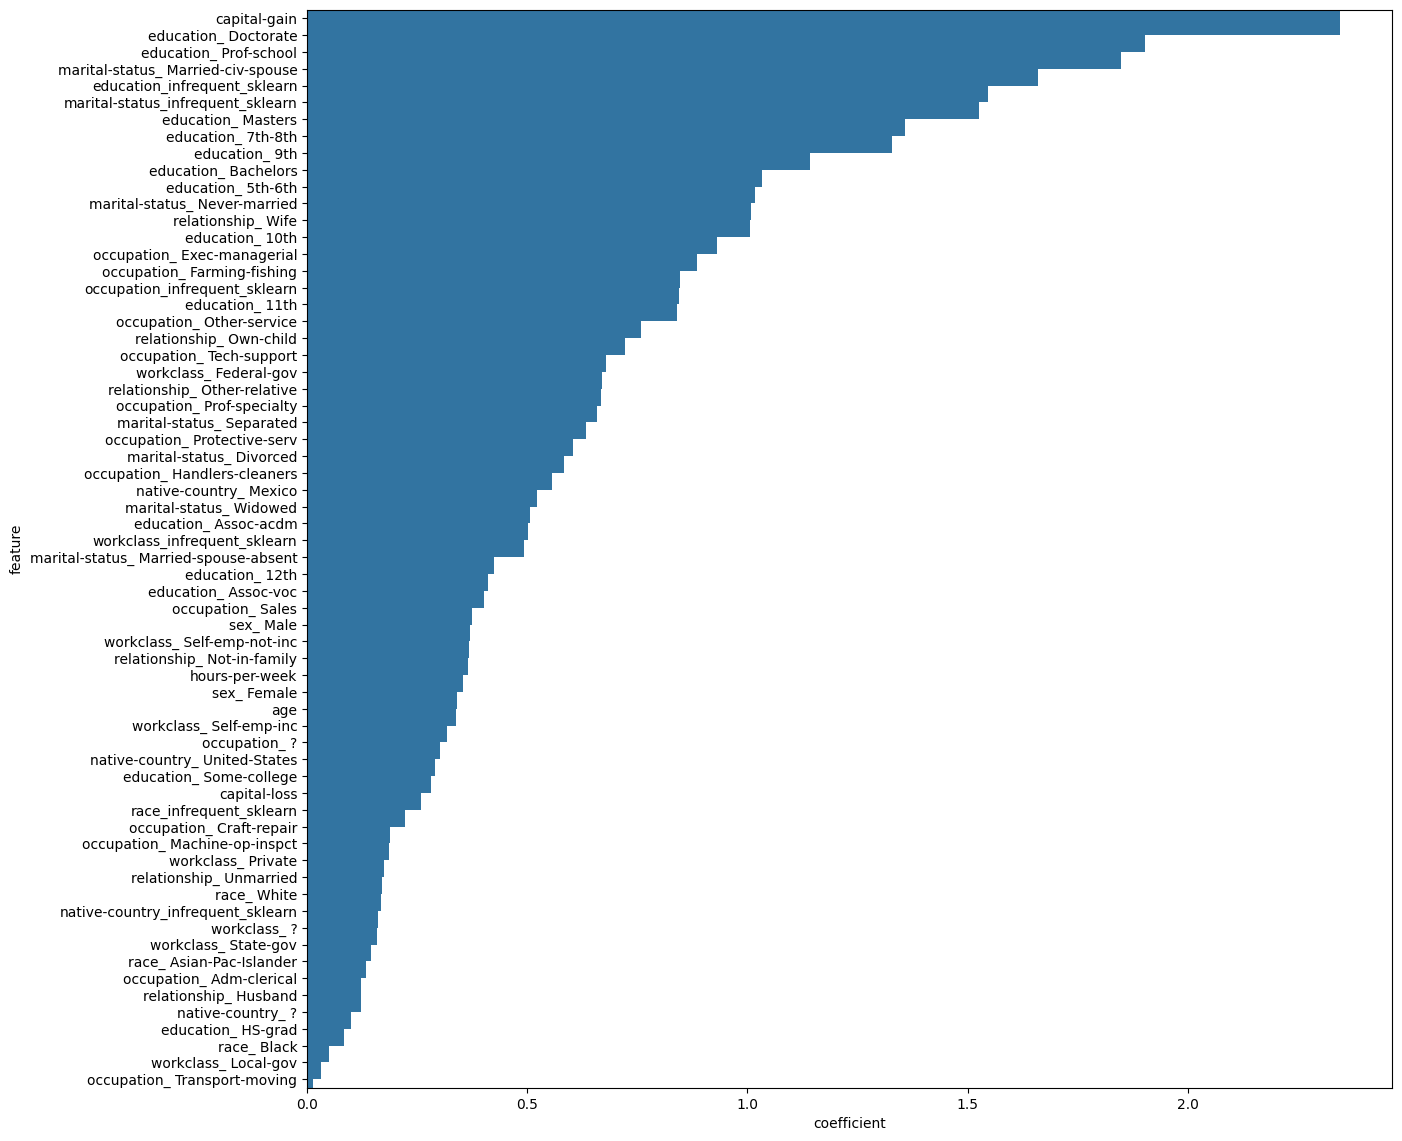

In [87]:
final_coefficients_data = dict(zip(feature_names, abs(np.ravel(full_model[-1].coef_))))
coefficients_df = pd.DataFrame(final_coefficients_data.items(), columns=['feature', 'coefficient'])
coefficients_df = coefficients_df.sort_values('coefficient', ascending=False)
plt.figure(figsize=(14,14))
sns.barplot(data=coefficients_df, x='coefficient', y='feature', width=2)

Now create a similar pipeline consisting of the same preprocessor as above,
followed by a `PolynomialFeatures` and a logistic regression with `C=0.01`.
Set `degree=2` and `interaction_only=True` to the feature engineering step.
Remember not to include a "bias" feature to avoid introducing a redundancy
with the intercept of the subsequent logistic regression.

In [40]:
# Write your code here.
# Write your code here.
from sklearn.preprocessing import PolynomialFeatures

fuller_model = make_pipeline(preprocessor,PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), LogisticRegression(max_iter=500, C=0.01))
fuller_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                min_frequency=0.01,
                                                                sparse_output=False),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['age', 'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('polynomialfeatures',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('logisticregression',
                 LogisticRegression(C=0.01, max_iter=500))])

By comparing the cross-validation test scores of both models fold-to-fold,
count the number of times the model using multiplicative interactions and both
numerical and categorical features has a better test score than the model
without interactions.

In [42]:
# Write your code here.
cv_results_3 = cross_validate(fuller_model, data, target, cv=10, return_estimator=True)

scores_fuller_model = cv_results_3["test_score"]

print(
    "The mean cross-validation test accuracy is: "
    f"{scores_fuller_model.mean():.3f} ± {scores_fuller_model.std():.3f} "
)

The mean cross-validation test accuracy is: 0.853 ± 0.002 


In [54]:
# Write your code here.
print('The scores for the full model are:', scores_full_model, sep='\n')
print('The scores for the "Fuller" model are:', scores_fuller_model, sep='\n')
print(f"fold-to-fold comparison: {(scores_fuller_model > scores_full_model).sum()}")

The scores for the full model are:
[0.853  0.8514 0.8495 0.8479 0.8483 0.8468 0.855  0.8501 0.8585 0.8518]
The scores for the "Fuller" model are:
[0.8547 0.8534 0.8526 0.853  0.8495 0.8501 0.8544 0.8526 0.8557 0.852 ]
fold-to-fold comparison: 8
